In [15]:
import pandas as pd
import numpy as np  
import pyarrow as pa
import pyarrow.parquet as pq
import os
import utils
import transforms
import geopandas as gpd
import matplotlib.pyplot as plt

In [16]:
# define the path to the parquet file
data_folder = '../data/crash_records/'
output_folder = '../data/crash_records_transformed/'

In [17]:
# Use PyArrow to read in the parquet files
dataset = pq.ParquetDataset(data_folder)
table = dataset.read()
collisions_df = table.to_pandas()

# Inspect the df
print('min_date', collisions_df.crash_date.min(), 'max date', collisions_df.crash_date.max())
print(f'shape {collisions_df.shape}')

min_date 2012-07-01T00:00:00.000 max date 2024-04-16T00:00:00.000
shape (2081608, 31)


## CLEAN DATA AND ASSIGN DTYPES

In [18]:
# Inspect the column
utils.nan_null_zero_datatypes(collisions_df)

,Column Name,# Non Zero Values,# NAs,# Blanks,# Zeros,# Data Types,Data Types
0,crash_date,2081608,0,0,0,1,[<class 'str'>]
1,crash_time,2081608,0,0,0,1,[<class 'str'>]
2,on_street_name,1639244,442364,0,0,2,"[<class 'str'>, <class 'NoneType'>]"
3,off_street_name,1293996,787612,0,0,2,"[<class 'str'>, <class 'NoneType'>]"
4,number_of_persons_injured,2081590,18,0,0,2,"[<class 'str'>, <class 'NoneType'>]"
5,number_of_persons_killed,2081577,31,0,0,2,"[<class 'str'>, <class 'NoneType'>]"
6,number_of_pedestrians_injured,2081608,0,0,0,1,[<class 'str'>]
7,number_of_pedestrians_killed,2081608,0,0,0,1,[<class 'str'>]
8,number_of_cyclist_injured,2081608,0,0,0,1,[<class 'str'>]
9,number_of_cyclist_killed,2081608,0,0,0,1,[<class 'str'>]


### DROP UNNECESSARY COLUMNS

In [19]:
# strip column names so they are recognized
collisions_df.columns = collisions_df.columns.str.strip()
drop_cols =['location.human_address', 'location.longitude', 'location.latitude']
collisions_df.drop(drop_cols, axis=1, inplace=True)

### CHECK FOR DUPLICATES </br> based on all rows and on just the collision id. 

In [20]:
# Check for duplicate rows based on all columns
duplicate_complete_rows = collisions_df[collisions_df.duplicated()]

# Check for duplicate based on collision_id only 
duplicate_rows = collisions_df[collisions_df.duplicated(subset=['collision_id'])]

# Print the number of duplicate rows
print('Number of duplicate rows based on all columns:', duplicate_complete_rows.shape[0])
print('Number of duplicate rows based on collision_id:', duplicate_rows.shape[0])

Number of duplicate rows based on all columns: 492
Number of duplicate rows based on collision_id: 492


In [7]:
# IDENTIFY COLLISION IDs WITH DUPLICATE VALUES

# Count the occurrences of each value in the 'collision_id' column
collision_id_counts = collisions_df['collision_id'].value_counts()

# Filter the collision_id values that have more than one occurrence
duplicate_collision_ids = collision_id_counts[collision_id_counts > 1]

if not duplicate_collision_ids.empty:
    print("Duplicate collision_id values found:")
    print(duplicate_collision_ids)
else:
    print("No duplicate collision_id values found.")

Duplicate collision_id values found:
collision_id
4573583    2
4170500    2
4161751    2
4167386    2
4161892    2
          ..
4545118    2
2889201    2
4545578    2
4680064    2
4545587    2
Name: count, Length: 492, dtype: int64


In [21]:
# REMOVE DUPLICATE ROWS - KEEPING THE FIRST OCCURRENCE

# Sort the DataFrame based on collision_id in ascending order
collisions_df.sort_values(by='collision_id', ascending=True, inplace=True)

# Identify duplicates and mark all but the last occurrence as True
duplicates_mask = collisions_df.duplicated(subset='collision_id', keep='first')

# Filter out the rows marked as duplicates
collisions_df = collisions_df[~duplicates_mask]

In [22]:
# CONFIRM THERE ARE NO MORE DUPLICATES 
duplicate_check = collisions_df[collisions_df.duplicated()]
print('Remaining Duplicates:', duplicate_check.shape[0])

Remaining Duplicates: 0


### ASSIGN DTYPES AND PROCESS SOME NULLS 

In [23]:
# Define cols that are floats, ints, and strings
# file NaN with 0 for int cols except for collision_id which should be unique
float_cols = ['latitude','longitude']
int_cols_no_fill = ['collision_id']
int_cols_fill_0 = [
    'number_of_persons_injured','number_of_pedestrians_injured','number_of_cyclist_injured',
    'number_of_motorist_injured','number_of_persons_killed','number_of_pedestrians_killed',
    'number_of_cyclist_killed','number_of_motorist_killed'
]
str_cols = [
    'zip_code','borough','on_street_name','off_street_name','cross_street_name',
    'contributing_factor_vehicle_1','contributing_factor_vehicle_2','contributing_factor_vehicle_3',
    'contributing_factor_vehicle_4','contributing_factor_vehicle_5','vehicle_type_code1',
    'vehicle_type_code2','vehicle_type_code_3','vehicle_type_code_4','vehicle_type_code_5'
]

In [24]:
# Convert cols to appropriate dtypes
collisions_df[float_cols] = collisions_df[float_cols].astype(float)
collisions_df[int_cols_no_fill] = collisions_df[int_cols_no_fill].astype(int)
collisions_df[int_cols_fill_0] = collisions_df[int_cols_fill_0].fillna(0).astype(int)
collisions_df[str_cols] = collisions_df[str_cols].astype(str)

In [25]:
utils.nan_null_zero_datatypes(collisions_df)

,Column Name,# Non Zero Values,# NAs,# Blanks,# Zeros,# Data Types,Data Types
0,crash_date,2081116,0,0,0,1,[<class 'str'>]
1,crash_time,2081116,0,0,0,1,[<class 'str'>]
2,on_street_name,2081116,0,0,0,1,[<class 'str'>]
3,off_street_name,2081116,0,0,0,1,[<class 'str'>]
4,number_of_persons_injured,476589,0,0,1604527,1,[<class 'int'>]
5,number_of_persons_killed,2995,0,0,2078121,1,[<class 'int'>]
6,number_of_pedestrians_injured,113033,0,0,1968083,1,[<class 'int'>]
7,number_of_pedestrians_killed,1528,0,0,2079588,1,[<class 'int'>]
8,number_of_cyclist_injured,55225,0,0,2025891,1,[<class 'int'>]
9,number_of_cyclist_killed,238,0,0,2080878,1,[<class 'int'>]


### PROCESS TIME COLUMNS 

In [26]:
collisions_df['crash_date'] = pd.to_datetime(collisions_df['crash_date'], format="%Y-%m-%dT%H:%M:%S.%f").dt.date
collisions_df['crash_datetime'] = pd.to_datetime((collisions_df['crash_date'].astype(str) + ' ' + collisions_df['crash_time'].astype(str)), format='%Y-%m-%d %H:%M')

In [27]:
collisions_df['crash_month']= collisions_df['crash_datetime'].dt.month
collisions_df['crash_year']= collisions_df['crash_datetime'].dt.year
collisions_df['crash_day']= collisions_df['crash_datetime'].dt.day
collisions_df['crash_weekday']= collisions_df['crash_datetime'].dt.weekday
collisions_df['crash_hour']= collisions_df['crash_datetime'].dt.hour
collisions_df['crash_month_year'] = collisions_df['crash_datetime'].dt.strftime('%Y-%m')

### Data Clean Up
- lat/lon = 0 is not valid. Convert to Null

In [28]:
collisions_df.loc[collisions_df['latitude'] == 0, 'latitude'] = np.nan 
collisions_df.loc[collisions_df['longitude'] == 0, 'longitude'] = np.nan 

In [29]:
utils.nan_null_zero_datatypes(collisions_df)

,Column Name,# Non Zero Values,# NAs,# Blanks,# Zeros,# Data Types,Data Types
0,crash_date,2081116,0,0,0,1,[<class 'datetime.date'>]
1,crash_time,2081116,0,0,0,1,[<class 'str'>]
2,on_street_name,2081116,0,0,0,1,[<class 'str'>]
3,off_street_name,2081116,0,0,0,1,[<class 'str'>]
4,number_of_persons_injured,476589,0,0,1604527,1,[<class 'int'>]
5,number_of_persons_killed,2995,0,0,2078121,1,[<class 'int'>]
6,number_of_pedestrians_injured,113033,0,0,1968083,1,[<class 'int'>]
7,number_of_pedestrians_killed,1528,0,0,2079588,1,[<class 'int'>]
8,number_of_cyclist_injured,55225,0,0,2025891,1,[<class 'int'>]
9,number_of_cyclist_killed,238,0,0,2080878,1,[<class 'int'>]


## ADDITIONAL CALCULATED COLUMNS 

### ADD SEVERITY

In [30]:
# ADD SEVERITY COLUMN
# fatal = >0 deaths, severe = >0 injuries, minor = 0 deaths and injuries
collisions_df['severity'] = np.where(collisions_df['number_of_persons_killed'] > 0, 'fatal',
                            np.where(collisions_df['number_of_persons_injured'] > 0, 'major', 'minor'))


### ADD SUN PHASE

In [31]:
collisions_df['sun_phase'] = collisions_df.apply(
    lambda row: transforms.nyc_sunphase(row['crash_datetime']), 
    axis=1
)

### ADD BOROUGH CLEAN UP AND NEIGHBORHOOD 
DATA SOURCE: </br> https://data.dathere.com/dataset/nyc-neighborhoods/resource/d6db2e12-fc58-4e41-bc58-5bdfb5078131

In [32]:
# Read in the NYC borough and neighborhood geojson file
polygon_file = '../data/nyc_borough_neighborhood.geojson'
gdf = gpd.read_file(polygon_file)

In [ ]:
collisions_df.dtypes

In [33]:
# Fill the borough Nones by looking up the borough from the GeoJSON df
collisions_df['borough'] = collisions_df.apply(
    lambda x: transforms.lon_lat_to_borough(x['longitude'], x['latitude'], gdf) 
            if x['borough'] == 'None' 
            else x['borough'].lower().title(), 
    axis=1
)

In [34]:
# Convert spaces to underscores in the borough names
collisions_df['borough'] = collisions_df['borough'].str.replace(' ', '_')
#collisions_df.loc[collisions_df['borough'] == 'Staten Island', 'borough'] = 'Staten_Island'

In [35]:
# Add the neighborhood column
collisions_df['neighborhood'] = collisions_df.apply(
    lambda x: transforms.lon_lat_to_neighborhood(x['longitude'], x['latitude'], gdf)
    , axis=1
)

### WRITE TRANSFORMED DATA TO FILE 

In [36]:
# Convert Pandas DataFrame to PyArrow Table
table = pa.Table.from_pandas(collisions_df)

In [37]:
# Check the datatypes of the table
schema = table.schema

# Get the field names and data types
for i, field in enumerate(schema):
    print(f"Column {i}: {field.name} - {field.type}")


Column 0: crash_date - date32[day]
Column 1: crash_time - string
Column 2: on_street_name - string
Column 3: off_street_name - string
Column 4: number_of_persons_injured - int64
Column 5: number_of_persons_killed - int64
Column 6: number_of_pedestrians_injured - int64
Column 7: number_of_pedestrians_killed - int64
Column 8: number_of_cyclist_injured - int64
Column 9: number_of_cyclist_killed - int64
Column 10: number_of_motorist_injured - int64
Column 11: number_of_motorist_killed - int64
Column 12: contributing_factor_vehicle_1 - string
Column 13: contributing_factor_vehicle_2 - string
Column 14: collision_id - int64
Column 15: vehicle_type_code1 - string
Column 16: vehicle_type_code2 - string
Column 17: borough - string
Column 18: zip_code - string
Column 19: latitude - double
Column 20: longitude - double
Column 21: cross_street_name - string
Column 22: contributing_factor_vehicle_3 - string
Column 23: vehicle_type_code_3 - string
Column 24: contributing_factor_vehicle_4 - string
Co

In [38]:
pq.write_to_dataset(table, root_path=output_folder, partition_cols=['crash_year','crash_month','borough'])

In [28]:
print(gdf.crs)
print(type(gdf))

EPSG:4326
<class 'geopandas.geodataframe.GeoDataFrame'>


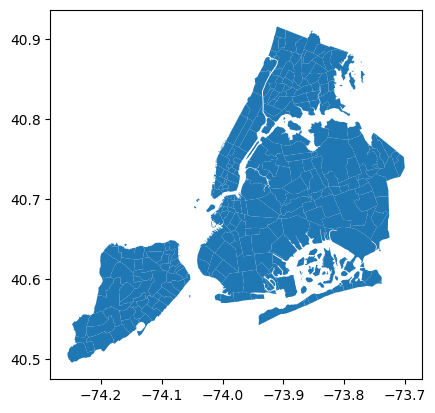

In [29]:
import matplotlib.pyplot as plt

# Plot the GeoDataFrame
gdf.plot()
plt.show()